In [1]:
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree

# Autoreload magic command
%load_ext autoreload
%autoreload 2

In [2]:
num_samples = 500
p1_range = [0, 1]
p2_range = [0, 1]


def f(p1, p2):
    return (p1 - 0.1) ** 2 + 4 * (p2 - 0.1) ** 2 - 0.64


def FI(df: pd.DataFrame) -> float:
    return len(df[df["label"] == 1]) / len(df)


# Generate a dataset
df = pd.DataFrame(columns=["p1", "p2", "f", "label"])
df["p1"] = np.random.uniform(p1_range[0], p1_range[1], num_samples)
df["p2"] = np.random.uniform(p2_range[0], p2_range[1], num_samples)
df["f"] = f(df["p1"], df["p2"])
df["label"] = (df["f"] < 0).astype(int)
df.drop("f", axis=1, inplace=True)

print(f"FI = {FI(df)}")

df.head()

FI = 0.374


,p1,p2,label
0,0.555666,0.108658,1
1,0.755804,0.398517,0
2,0.632536,0.079676,1
3,0.557980,0.835451,0
4,0.404245,0.276517,1


In [3]:
def train_cart(df: pd.DataFrame, label: str) -> DecisionTreeClassifier:
    cart = DecisionTreeClassifier()
    X = df.drop(columns=[label])
    y = df[label]
    
    # Define parameter grid
    param_grid = {
        'max_depth': np.arange(2, 12, 1),
        'min_samples_split': np.arange(0, int(len(df) * .8), 1),
        'min_samples_leaf': np.arange(1, int(len(df) * .8), 1),
    }
    
    search = RandomizedSearchCV(cart, param_grid, n_iter=100, cv=5, scoring='accuracy', n_jobs=-1)
    search.fit(X, y)
    cart = search.best_estimator_
    print(f"Best parameters: {search.best_params_}")
    print(f"Best score: {search.best_score_}")
    return cart

In [4]:
cart = train_cart(df, "label")

Best parameters: {'min_samples_split': 55, 'min_samples_leaf': 23, 'max_depth': 6}
Best score: 0.922


In [5]:
from ml2rules.machinelearning import MyClass

my_class = MyClass(df, 'label', cart)
my_class.get_rules()
my_class.rules

['if (p2 > 0.479) and (p2 > 0.515) then class: 1 (proba: 100.0%) | based on 232 samples',
 'if (p2 <= 0.479) and (p1 <= 0.749) and (p2 <= 0.441) and (p2 <= 0.337) then class: 0 (proba: 100.0%) | based on 124 samples',
 'if (p2 <= 0.479) and (p1 > 0.749) and (p2 > 0.203) then class: 1 (proba: 97.14%) | based on 35 samples',
 'if (p2 <= 0.479) and (p1 > 0.749) and (p2 <= 0.203) then class: 0 (proba: 57.14%) | based on 35 samples',
 'if (p2 <= 0.479) and (p1 <= 0.749) and (p2 > 0.441) then class: 0 (proba: 60.71%) | based on 28 samples',
 'if (p2 > 0.479) and (p2 <= 0.515) then class: 1 (proba: 86.96%) | based on 23 samples',
 'if (p2 <= 0.479) and (p1 <= 0.749) and (p2 <= 0.441) and (p2 > 0.337) then class: 0 (proba: 95.65%) | based on 23 samples']

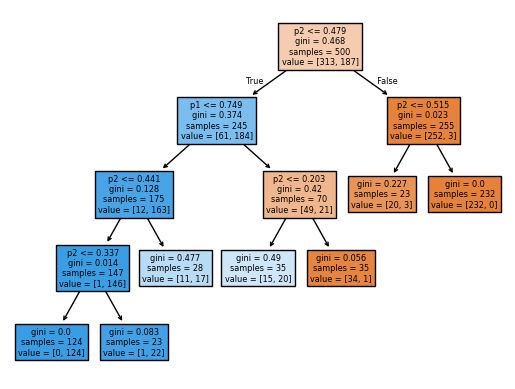

In [6]:
my_class.visualize_tree()

In [7]:
rdf = my_class.get_rules_df()
rdf

,feature,ineq,value,rule,class
0,p2,<=,0.4786,0,1.0
1,p1,<=,0.7493,0,1.0
2,p2,<=,0.4409,0,1.0
3,p2,<=,0.3370,0,1.0
4,p2,>,0.3370,1,1.0
5,p2,>,0.4409,2,1.0
6,p1,>,0.7493,3,1.0
7,p2,<=,0.2028,3,1.0
8,p2,>,0.2028,4,0.0
9,p2,>,0.4786,5,0.0
